<a href="https://colab.research.google.com/github/Raj-dot-GitHub/NLP-Projects/blob/main/Spam_Ham_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Importing Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from string import punctuation

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

from tqdm import tqdm
import os
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    plot_confusion_matrix,
    f1_score,
    roc_auc_score,
)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

In [10]:
# Loading the dataset:
df = pd.read_csv("spam.csv", encoding = "latin1")

In [11]:
df = df.iloc[:,[0,1]]
df.columns = ["Label","Message"]
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## EDA:

In [12]:
df.describe().T

,count,unique,top,freq
Label,5572,2,ham,4825
Message,5572,5169,"Sorry, I'll call later",30


In [13]:
df.groupby("Label").describe()

Message                                                               
        count unique                                                top freq
Label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [14]:
# Adding a 'Length' column.
df["Length"] = df["Message"].apply(len)

In [15]:
df.head()

,Label,Message,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [16]:
df["Length"].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: Length, dtype: float64

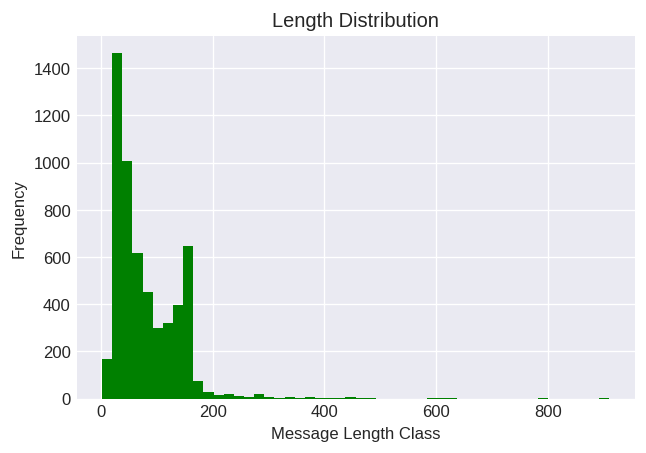

In [17]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(dpi = 120)
ax = plt.axes()
df['Length'].plot(bins=50, kind='hist',ax=ax,color = 'green')
ax.set(xlabel = 'Message Length Class',ylabel = 'Frequency',title = 'Length Distribution');

In [18]:
# Let's find the instance where the text length is equal to 910 to show the message:
df[df["Length"] == 910]["Message"].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

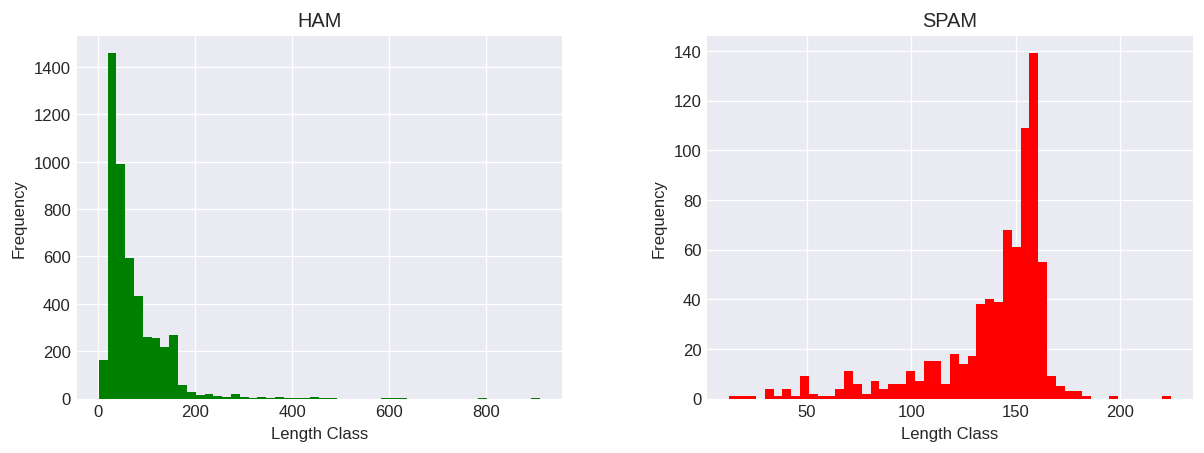

In [19]:
fig,ax = plt.subplots(1,2,figsize=(12,4),dpi = 120)

df[df['Label']=='ham'].hist(column='Length', bins=50,ax=ax[0],color = 'green')
ax[0].set(xlabel = 'Length Class',ylabel = 'Frequency',title = 'HAM')
df[df['Label']=='spam'].hist(column='Length', bins=50,ax=ax[1],color = 'red')
ax[1].set(xlabel = 'Length Class',ylabel = 'Frequency',title = 'SPAM');

In [20]:
balance_counts = df.groupby('Label')['Label'].agg('count').values
balance_counts

array([4825,  747])

In [21]:
# Distribution of 'Label':
fig = go.Figure()
fig.add_trace(go.Bar(x = ['ham'],
                     y = [balance_counts[0]],
                     name = 'ham',
                     text = [balance_counts[0]],
                     textposition = 'auto',
                     marker_color = primary_blue))
fig.add_trace(go.Bar(
    x = ['spam'],
    y = [balance_counts[1]],
    name = 'spam',
    text = [balance_counts[1]],
    textposition = 'auto',
    marker_color = primary_grey
))
fig.update_layout(
    title = '<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

## Data Preprocessing

In [22]:
df = df.replace({'ham': 0,'spam': 1})
df.head()

,Label,Message,Length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [23]:
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
    "stopwords"
):
    nltk.download(dependency)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
stop_words =  stopwords.words('english')

def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"ur", " your ", text)
    text = re.sub(r" nd "," and ",text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r" tkts "," tickets ",text)
    text = re.sub(r" c "," can ",text)
    text = re.sub(r" e g ", " eg ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = re.sub(r" u "," you ",text)
    text = text.lower()  # set in lowercase 
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)

In [33]:
#clean the dataset 
df["clean_message"] = df["Message"].apply(text_cleaning)

In [34]:
df['clean_message'].iloc[0]

'go j ong point crazy available bugis n great world la e buffet cine got amore wat'

In [35]:
df.head()

,Label,Message,Length,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",111,go j ong point crazy available bugis n great w...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final ticket 2...
3,0,U dun say so early hor... U c already then say...,49,u dun say early hor u already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think go usf life around though


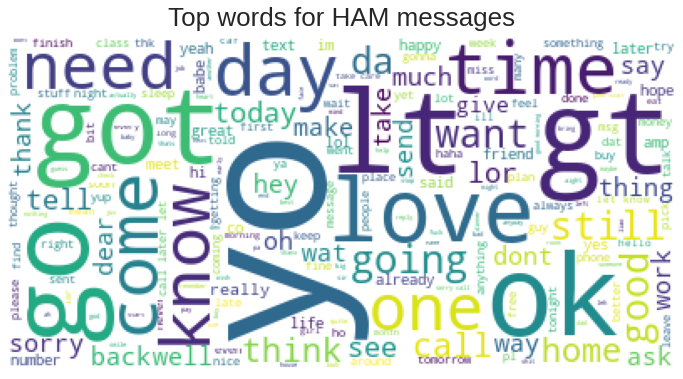

In [39]:
wc = WordCloud(
    background_color='white', 
    max_words=200,
)
wc.generate(' '.join(text for text in df.loc[df['Label'] == 0, 'clean_message']))
plt.figure(figsize=(12,7))
plt.title('Top words for HAM messages', 
          fontdict={'size': 26,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()


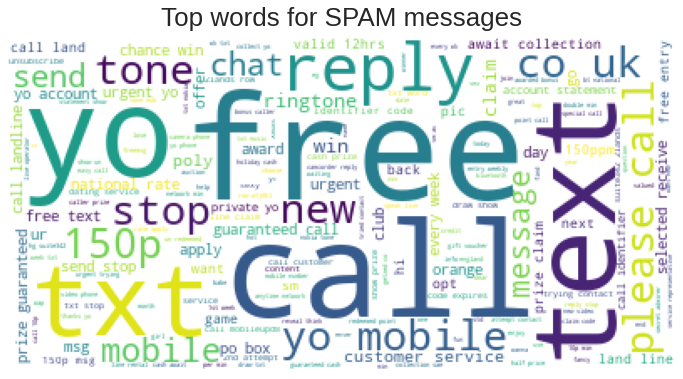

In [38]:
wc = WordCloud(
    background_color='white', 
    max_words=200,
)
wc.generate(' '.join(text for text in df.loc[df['Label'] == 1, 'clean_message']))
plt.figure(figsize=(12,7))
plt.title('Top words for SPAM messages', 
          fontdict={'size': 26,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()


In [40]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_message"],
    df["Label"],
    test_size=0.2,
    random_state=0,
    shuffle=True,
    stratify=df["Label"])

## Transform text data

In [41]:
 vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)

#transform train data 
X_train_trans = vectorizer.transform(X_train)

#transform test data
X_text_trans = vectorizer.transform(X_test)

## Create a classifier

In [52]:
spam_classifier = MultinomialNB()

## Train the model with cross validation

In [43]:
scores = cross_val_score(spam_classifier,X_train_trans,y_train,cv=10,verbose=3,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished


In [44]:
# find the mean of the all scores
scores.mean()

0.9755469340454475

## Fine turning model parameters

In [45]:
distribution = {"alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0, 0.2, 0.3]}

grid = RandomizedSearchCV(
    spam_classifier,
    param_distributions=distribution,
    n_jobs=-1,
    cv=10,
    n_iter=20,
    random_state=42,
    return_train_score=True,
    verbose=2,
)

## Training with randomized search

In [46]:
grid.fit(X_train_trans, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.4s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                           fit_prior=True),
                   iid='deprecated', n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [1, 0.1, 0.01, 0.001, 0.0001,
                                                  0, 0.2, 0.3]},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=True, scoring=None, verbose=2)

In [47]:
# summarize the results of the random parameter search
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.9777900942207891
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
{'alpha': 0.01}


In [48]:
spam_classifier = MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
spam_classifier.fit(X_train_trans,y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [49]:
# predict on the test data
y_pred = spam_classifier.predict(X_text_trans)

In [50]:
# check accuracy score
accuracy_score(y_test, y_pred)

0.9757847533632287

In [51]:
# check f1_ score
f1_score(y_test, y_pred)

0.9078498293515358